# Определение возраста покупателей

**Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:**
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

**Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.**

**План проекта:**
- Провести исследовательский анализ набора фотографий.
- Подготовить данные к обучению.
- Обучить нейронную сеть и рассчитать её качество.
- описать результаты и выводы.

## Исследовательский анализ данных

**Импортирование библиотек и загрузка данных**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
# Выведем общую информацию о датасете.
print(labels.shape);
print(labels.info());
print(labels.describe());

(7591, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None
          real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000


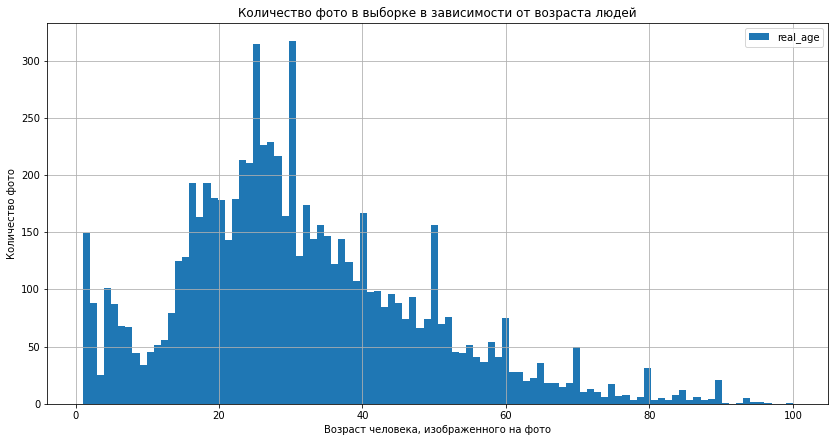

In [4]:
labels.plot(y='real_age', kind='hist', bins=100, grid=True, figsize=(14, 7))
plt.xlabel('Возраст человека, изображенного на фото')
plt.ylabel('Количество фото')
plt.title("Количество фото в выборке в зависимости от возраста людей")
plt.show()

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


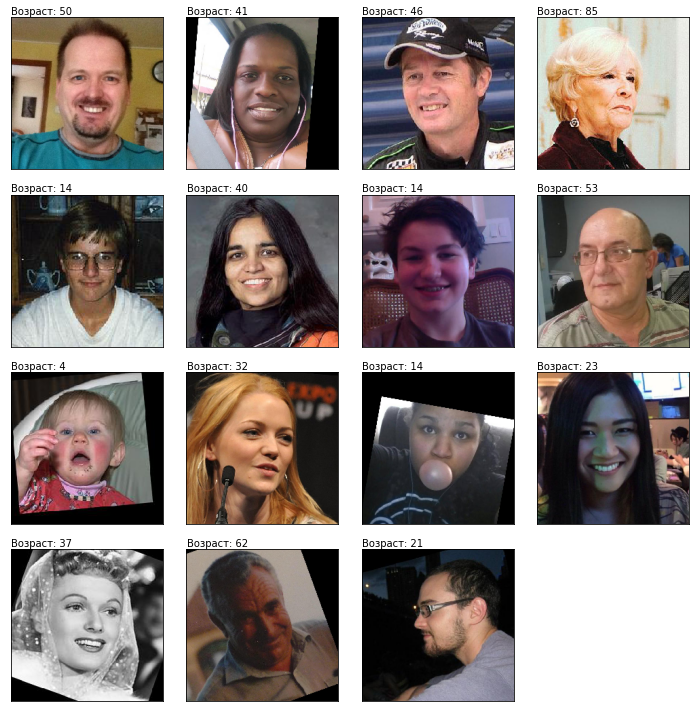

In [6]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.text(0, -5, f"Возраст: {target[i]}")
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Вывод**
- В выборке 7591 фотография людей с отметкой их возраста.
- Минимальный возраст 1 год, максимальный - 100 лет, медиана - 29 лет, средний возраст - 31 год.
- Основное количество людей на фотографиях в возрасте от 16-17 до 37-38 лет, также отмечается достаточное количество фото с младенцами (1-2 года). 
- На фотографиях присутствуют как знаменитости мирового масштаба так и малоизвестне личности.
- На фото могут быть люди в головных уборах, в очках, с длинными волосами, закрывающими часть лица, могут присутствовать двое человек, также фото разного качества, яркости и контрастности, с разным уровнем освещенности, все это затрудняет предсказание модели.
- на фото присутсвуют люди с разным расположением лица, с опущенными глазами, на фото люди могут быть в полный рост и/или немного наклонены, но в основном расположение вертикальное.
- распределение фото по возрастам можно считать нормальным. Большое количество фото детей возможно объясняется частотой их съемки родителями, а малое количесвто фото очень старых людей можно объяснить высокой их смертностью, либо нежеланием фотографироваться. 
- все изображения приведены к размеру 224х224 пикселей. Нейронным сетям необходимо, чтобы фото были одинакового размера, а в датасете они могут иметь разный размер.

## Обучение модели

```python

import pandas as pd
import numpy as np
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, 
                                       rescale=1./255,
                                       horizontal_flip=True,
                                       vertical_flip=True)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=91023)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=91023)

    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    
    optimizer = Adam(lr=0.0001)

    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    return model 

def train_model(model, train_data, test_data, batch_size=None, epochs=7,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
        
    model.fit(train_data, validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
              
    return model

```

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps
Epoch 1/7
356/356 - 51s - loss: 239.4569 - mae: 11.3780 - val_loss: 652.2497 - val_mae: 20.5221
Epoch 2/7
356/356 - 42s - loss: 116.5091 - mae: 8.1925 - val_loss: 198.7316 - val_mae: 11.0370
Epoch 3/7
356/356 - 42s - loss: 93.0736 - mae: 7.3582 - val_loss: 119.7560 - val_mae: 8.2776
Epoch 4/7
356/356 - 42s - loss: 75.4706 - mae: 6.6965 - val_loss: 74.8252 - val_mae: 6.5860
Epoch 5/7
356/356 - 42s - loss: 62.5031 - mae: 6.0807 - val_loss: 111.7541 - val_mae: 8.1328
Epoch 6/7
356/356 - 39s - loss: 53.8714 - mae: 5.6104 - val_loss: 127.1089 - val_mae: 8.8665
Epoch 7/7
356/356 - 39s - loss: 46.4461 - mae: 5.1949 - val_loss: 85.1000 - val_mae: 6.8331

119/119 - 10s - loss: 85.1000 - mae: 6.8331
Test MAE: 6.8331
```

**Выборка поделена на обучающую и тестовую в соотношении 75:25. Итоговый MAE на тестовой выборке составил 6,83 года, что удовлетворяет условию задачи.**

## Анализ обученной модели

- В проекте использовалась сеть ResNet50, в которой количество слоев составляет 50. Особенность ResNet заключается в использовании дополнительных связей внутри сети, которые позволяют избежать проблемы затухающего градиента, тоесть когда сеть перестает обучаться.
- Данная сеть позволяет получить нужные метрики за короткое время.
- Итоговый MAE на тестовой выборке составил 6,83 года, что удовлетворяет условию задачи.